In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                       images/
__pycache__/                    jobs/
algorithm_compare_results/      low-dimension-search-results/
data/                           models/
data-queue/                     paper-images/
data-queue-2023-09-24/          requirements.txt
data-queue-2023-09-27/          results/
deeplifting/                    search_results/
deeplifting.png                 tasks.py
high-dimension-paper-results/   test-low-dimension-results.png
high-dimension-search-results/


In [4]:
import glob as glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

# Utils

In [5]:
# Utility function for renaming
problem_name_mapping = {
    'ackley3': 'Ak3',
    'alpine1': 'Al1',
    'bird': 'Bd',
    'bohachevsky2': 'By2',
    'bohachevsky3': 'By3',
    'bukin_n2': 'Bk2',
    'bukin_n4': 'Bk4',
    'camel_3hump': 'C3h',
    'chung_reynolds': 'CR',
    'cross_leg_table': 'CLT',
    'eggholder': 'Eh',
    'griewank': 'Gw',
    'holder_table': 'HTable',
    'levy': 'Ly',
    'levy_n13': 'Ly13',
    'schaffer_n2': 'Sc2',
    'schaffer_n4': 'Sc4',
    'schwefel': 'Swl',
    'shubert': 'Sbt',
    'xinsheyang_n3': 'XSY3',
}


def build_dl_results(files):
    """
    build deeplifting results from files
    """
    deeplifting_df = pd.read_parquet(deeplifting_files)

    # We need to create the hits column
    deeplifting_df['hits'] = (
        np.abs(deeplifting_df['global_minimum'] - deeplifting_df['f']) <= 1e-4
    )

    # Deeplifting groupby columns
    groupby_columns = [
        'problem_name',
        'algorithm',
        'input_size',
        'hidden_size',
        'hidden_activation',
        'output_activation',
        'agg_function',
        'include_bn',
    ]

    # Final deeplifting results columns
    columns = ['problem_name', 'algorithm', 'success rate']

    # Find the best neural network for the problem
    deeplifting_results_df = (
        deeplifting_df.groupby(groupby_columns)
        .agg({'hits': 'mean'})
        .reset_index()
        .sort_values(['problem_name', 'hits'], ascending=[True, False])
        .reset_index(drop=True)
    )

    # Get the best result
    deeplifting_results_df = deeplifting_results_df.groupby(['problem_name']).first()
    deeplifting_results_df = deeplifting_results_df.reset_index().rename(
        columns={'hits': 'success rate'}
    )

    return deeplifting_results_df

# Load in the algorithm comparison results

In [6]:
algorithm_file_directory = './algorithm_compare_results/low-dimensional/*/*'
algorithm_files = glob.glob(algorithm_file_directory)
algorithm_df = pd.read_parquet(algorithm_files)
algorithm_df.head()

,x1,x2,f,algorithm,time,problem_name,hits,dimensions
0,1.0,-0.092994,8.952825e-02,IPOPT,0.023972,levy,0,2
1,1.0,1.000000,3.917161e-17,IPOPT,0.043746,levy,1,2
2,1.0,1.000000,2.982301e-17,IPOPT,0.036035,levy,1,2
3,1.0,1.000000,2.975505e-17,IPOPT,0.017816,levy,1,2
4,1.0,1.000000,3.018360e-17,IPOPT,0.024534,levy,1,2


In [7]:
# Generate the results for the algorithms
algorithm_results_df = (
    algorithm_df.groupby(['problem_name', 'algorithm'])
    .agg({'hits': 'mean'})
    .reset_index()
    .rename(columns={'hits': 'success rate'})
)
algorithm_results_df.head()

,problem_name,algorithm,success rate
0,ackley,Differential Evolution,1.0
1,ackley,Dual Annealing,1.0
2,ackley,IPOPT,0.0
3,ackley,PyGRANSO,0.0
4,ackley,SCIP,1.0


# Generate the deeplifting results

In [8]:
deeplifting_file_directory = './data-queue-2023-09-24/low-dimension-deeplifting/*/*'
deeplifting_files = glob.glob(deeplifting_file_directory)

deeplifting_df_list = []
for file in deeplifting_files:
    df = pd.read_parquet(file)
    deeplifting_df_list.append(df)

deeplifting_df = pd.concat(deeplifting_df_list, ignore_index=True)

# We need to create the hits column
deeplifting_df['hits'] = (
    np.abs(deeplifting_df['global_minimum'] - deeplifting_df['f']) <= 1e-4
)
deeplifting_df.head()

,x1,x2,f,algorithm,total_time,input_size,hidden_size,hidden_activation,output_activation,agg_function,include_bn,problem_name,global_minimum,dimensions,hits
0,6.777955e-01,4.518632e-01,9.044953e-01,Deeplifting,0.263143,8,256-256,sine,sine,max,True,bohachevsky3,0.0,2,False
1,-3.393255e-01,-2.262170e-01,2.262600e-01,Deeplifting,2.373970,8,256-256,sine,sine,max,True,bohachevsky3,0.0,2,False
2,3.393255e-01,2.262170e-01,2.262600e-01,Deeplifting,0.318830,8,256-256,sine,sine,max,True,bohachevsky3,0.0,2,False
3,1.211764e-08,-1.266799e-08,7.216450e-16,Deeplifting,4.348410,8,256-256,sine,sine,max,True,bohachevsky3,0.0,2,True
4,9.284893e-10,-5.289333e-10,0.000000e+00,Deeplifting,9.449283,8,256-256,sine,sine,max,True,bohachevsky3,0.0,2,True


In [9]:
# Deeplifting groupby columns
groupby_columns = [
    'problem_name',
    'algorithm',
    'input_size',
    'hidden_size',
    'hidden_activation',
    'output_activation',
    'agg_function',
    'include_bn',
]

# Final deeplifting results columns
columns = ['problem_name', 'algorithm', 'success rate']

# Find the best neural network for the problem
deeplifting_results_df = (
    deeplifting_df.groupby(groupby_columns)
    .agg({'hits': 'mean'})
    .reset_index()
    .sort_values(['problem_name', 'hits'], ascending=[True, False])
    .reset_index(drop=True)
)

# Get the best result
deeplifting_results_df = deeplifting_results_df.groupby(['problem_name']).first()
deeplifting_results_df = deeplifting_results_df.reset_index().rename(
    columns={'hits': 'success rate'}
)

# Filter columns for combining data
deeplifting_results_df = deeplifting_results_df[columns]
deeplifting_results_df.sort_values(
    ['success rate', 'problem_name'], ascending=[False, True]
)

,problem_name,algorithm,success rate
1,ackley2,Deeplifting,1.0
3,adjiman,Deeplifting,1.0
4,alpine1,Deeplifting,1.0
6,bartels_conn,Deeplifting,1.0
7,beale,Deeplifting,1.0
8,bird,Deeplifting,1.0
12,booth,Deeplifting,1.0
13,branin_rcos,Deeplifting,1.0
14,brent,Deeplifting,1.0
15,bukin_n2,Deeplifting,1.0


In [10]:
deeplifting_results_df['success rate'].mean()

0.875

In [11]:
# Need to work the eggholder, griewank and schwefel

In [12]:
# Combine all results
results_df = pd.concat([algorithm_results_df, deeplifting_results_df], axis=0)

# Lets rename some of the algorithms for space
algorithm_map = {
    'Differential Evolution': 'DE',
    'Dual Annealing': 'DA',
    'Deeplifting': 'DL',
    'PyGRANSO': 'PG',
    'IPOPT': 'IPOPT',
    'SCIP': 'SCIP',
}

# Make updates to naming
results_df['algorithm'] = results_df['algorithm'].map(algorithm_map)
# results_df['problem_name'] = results
results_df.head()

,problem_name,algorithm,success rate
0,ackley,DE,1.0
1,ackley,DA,1.0
2,ackley,IPOPT,0.0
3,ackley,PG,0.0
4,ackley,SCIP,1.0


In [13]:
# Let's create the final plot and heat map
# Let's try a heat map to look at all problems
fn_results_df = results_df.pivot_table(
    index='problem_name', columns='algorithm', values='success rate'
).fillna(0.0)

# Order the columns
column_order = ['DL', 'DA', 'DE', 'IPOPT', 'PG', 'SCIP']
fn_results_df = fn_results_df[column_order]
fn_results_df.sort_values('DL')

algorithm,DL,DA,DE,IPOPT,PG,SCIP
problem_name,,,,,,
bukin_n6,0.2,0.0,0.0,0.0,0.0,1.0
cross_leg_table,0.4,0.0,0.0,0.0,0.0,0.0
eggholder,0.4,0.6,0.2,0.0,0.0,1.0
griewank,0.4,0.4,0.8,0.0,0.0,1.0
mathopt6,0.4,0.4,0.3,0.0,0.0,1.0
schaffer_n4,0.6,1.0,1.0,0.0,0.0,1.0
schaffer_n2,0.8,1.0,1.0,0.1,0.0,1.0
levy_n13,0.8,1.0,0.9,0.0,0.0,1.0
bohachevsky1,0.8,1.0,1.0,0.4,0.1,1.0


In [14]:
fn_results_df.mean()

algorithm
DL       0.8750
DA       0.8800
DE       0.8350
IPOPT    0.4450
PG       0.3975
SCIP     0.9250
dtype: float64

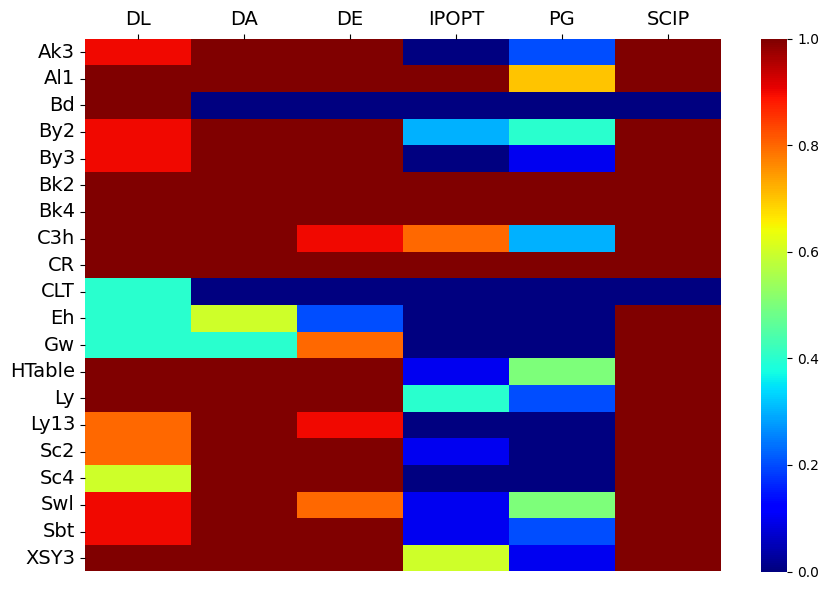

In [15]:
# Get a sample of the data
np.random.seed(0)
sampled_results = fn_results_df.sample(frac=0.50).sort_index()
sampled_results.index = sampled_results.index.map(problem_name_mapping)

# Generate the heatmap
fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

sns.heatmap(
    data=sampled_results,
    cmap='jet',
    ax=ax1,
    # annot=True,
    # fmt=".1f"
)
ax1.xaxis.tick_top()
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set(xlabel="", ylabel="")

fig.tight_layout()
# fig.savefig('./paper-images/2d-heatmap-results.png', bbox_inches='tight')

# Rectification

In [ ]:
deeplifting_file_directory = './low-dimension-search-results/*/*'
deeplifting_files = glob.glob(deeplifting_file_directory)
print(len(deeplifting_files))

updated_deeplifting_df = build_dl_results(deeplifting_files)

In [ ]:
updated_deeplifting_df

In [16]:
# Save the dataset
sampled_results.reset_index().to_parquet('./data/low-dimension-sampled-results.parquet')